In [1]:
import numpy as np
import random
import variables as var
import functions as func
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

In [2]:
font = {'family' : 'normal',
        'size'   : 50}

plt.rc('font', **font)

In [3]:
T_Y = var.T_Y  #timing for yellow phase
T_G = var.T_G #timing for green phase
T_R = var.T_R #timing for red phase
total_T = T_Y + T_G + T_R

d_lower = var.d_lower #lower bound for the initial distribution of distance
d_upper = var.d_upper #upper bound for the initial distribution of distance
v_lower = var.v_lower #lower bound for the initial distribution of velocity
v_upper = var.v_upper #upper bound for the initial distribution of velocity

delta_t = var.delta_t

phi_to_T_dict = {'Y': T_Y, 'G': T_G, 'R': T_R} #dictionary to map each phase to its timing
phi_to_next_phi_dict = {'G':'Y', 'Y':'R', 'R':'G'} #dictionary to map each phase to its next phase
phi_prev_phi_dict = var.phi_prev_phi_dict #dictionary to map each phase to its previous phase

episodes = var.episodes #maximum number for the length of the trajectory

learning_rate = 0.001 #learning_rate for the training phase of Q-learning
discount_factor = var.discount_factor #discount factor for the training phase of Q-learning
epsilon = 0 #set the epsilon to zero while testing

actions = var.actions #action space
discrete_d = var.discrete_d #list of discrete distances, used for discretization of the distance in state space
v_max= var.v_max #maximum allowed velocity
discrete_v = var.discrete_v #list of discrete velocities, used for discretization of the velocity in state space
discrete_phi_t = var.discrete_phi_t #list of discrete pairs of (phi, t_phi), used for discretization of the (phi, t_phi) in state space


In [4]:
def accumulate(reward_list):
    '''
    returns the average reward at each time step
    '''
    #compute the accumulative rewards for each trajectory 
    accum_reward_list=[]
    for l in reward_list:
        accum_rewards = [sum(l[:i+1]) for i in range(len(l))]
        accum_reward_list.append(accum_rewards)
    
    #at each step, compute the average of accumulated rewards for all trajectories that have value at that time step
    step = max([len(item) for item in accum_reward_list])
    avg = []
    for i in range(step):
        candids = [item for item in accum_reward_list if len(item)>i]
        
        summed = sum([item[i] for item in candids])
        avg.append(summed/len(candids))
    return avg

In [5]:
with open('Q_table_0.5_0.25_0.npy','rb') as f:#load q-table for regular q-learning
    Q_table = np.load(f)
print(f'Percentage of non-zero elements in Qtable:{len(Q_table[Q_table!=0])/(Q_table.shape[0]*Q_table.shape[1])}')

Percentage of non-zero elements in Qtable:0.8907563025210085


In [7]:
with open('MINMAX_Q_table_0.5_0.25_0.npy','rb') as f:#load q-table for minmax q-learning
    minmax_Q_table = np.load(f)
print(f'Percentage of non-zero elements in Qtable:{len(minmax_Q_table[minmax_Q_table!=0])/(minmax_Q_table.shape[0]*minmax_Q_table.shape[1])}')


Percentage of non-zero elements in Qtable:0.9411764705882353


In [10]:
init_states=func.read_list('CAI2023_init_states_2')#initial states

In [52]:
diff=0
while diff<0.013:

    trs=[]
    acs=[]
    accum_rewards = []
    step_count = []
    rrl_count=0
    rewards=[]
    nonrrl_rewards=[]

    minmax_accum_rewards = []
    minmax_step_count = []
    minmax_rrl_count=0
    minmax_rewards=[]
    minmax_nonrrl_rewards=[]

    traj_count=3000
    for i in tqdm(range(traj_count)):

        init_state=init_states[i]

        '''Qlearning with Small Noise'''
        std_d= 0.5
        std_v= 0.25
        std_t_phi= 0
        accum_r = 0

        idx_i = func.map_state_to_idx(init_state, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R, phi_prev_phi_dict)#find the index of initial state in the Q-table

        state=init_state
        distance = state[0]
        velocity = state[1]
        count=0
        rew=[]
        while (distance>=0): #while the vehicle has not reached the intersection
            count+=1
            action, action_idx = func.action_selection(Q_table[idx_i], velocity, actions, 0, v_max,0)#selects the best action, greedy approach (epsilon=0)
            state_new = func.update_state(state, action, delta_t, phi_to_T_dict, phi_to_next_phi_dict, std_d, std_v, std_t_phi,0)#update the state with the selected action
            idx_i_new = func.map_state_to_idx(state_new, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R, phi_prev_phi_dict)#index of the new state in Q-table
            distance = state_new[0]
            velocity = state_new[1]
            phi = state_new[2]
            t_phi = state_new[3]
            reward = func.reward_function(distance, velocity, phi, t_phi, v_max, T_Y)#reward of going to the new state
            rew.append(reward)
            accum_r+=reward#accumulative reward
            state=state_new
            idx_i=idx_i_new

        accum_rewards.append(accum_r)
        step_count.append(count)
        rewards.append(rew)

        if (state[0]<0) and (state[1]>0) and (state[2]=='R'):#count the number of RRLs with regular Q-learning
            rrl_count+=1
#         if reward>=-2:#
#             nonrrl_rewards.append(rew)

        #repeating the procedure explained above for the min-max q-learning
        '''MinMax Q learning with Small Noise'''
        std_d= 0.5#
        std_v= 0.25
        std_t_phi= 0
        accum_r = 0
        state = init_state
        idx_i = func.map_state_to_idx(state, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R, phi_prev_phi_dict)
        distance = state[0]
        velocity = state[1]
        count = 0
        rew=[]
        while (distance>=0):
            count+=1
            action, action_idx, _ = func.minmax_action_selection(minmax_Q_table[idx_i], velocity, actions, 0, v_max, 0)#select the action based on the Q-table learned with minmax q-learning
            state_new = func.update_state(state, action, delta_t, phi_to_T_dict, phi_to_next_phi_dict, std_d, std_v, std_t_phi,0)#update the state with the selected action
            idx_i_new = func.map_state_to_idx(state_new, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R, phi_prev_phi_dict)#map the new state to an index in the Q-table
            distance = state_new[0]
            velocity = state_new[1]
            phi = state_new[2]
            t_phi = state_new[3]
            reward = func.reward_function(distance, velocity, phi, t_phi, v_max, T_Y)#reward of going to the new state
            rew.append(reward)
            accum_r+=reward
            state=state_new
            idx_i=idx_i_new

        minmax_accum_rewards.append(accum_r)
        minmax_step_count.append(count)
        minmax_rewards.append(rew)
        if (state[0]<0) and (state[1]>0) and (state[2]=='R'):#count the number of RRLs in minmax Q-learning
            minmax_rrl_count+=1
#         if reward>=-2:
#             minmax_nonrrl_rewards.append(rew)

    rrl_percentage=(rrl_count)/traj_count
    minmax_rrl_percentage=(minmax_rrl_count)/traj_count

    diff = (rrl_percentage-minmax_rrl_percentage)


  9%|▊         | 257/3000 [00:00<00:10, 264.22it/s]


KeyboardInterrupt: 

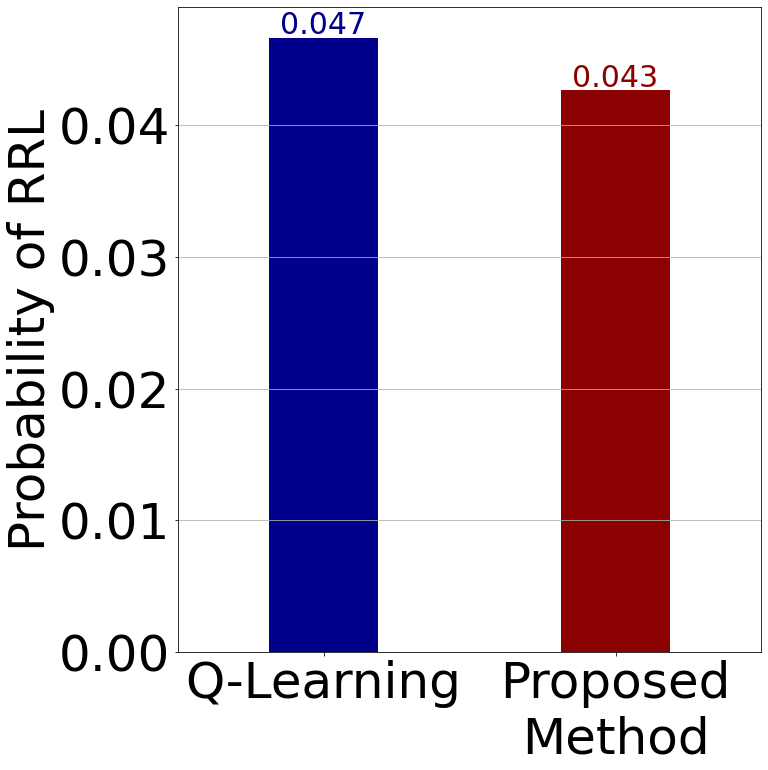

In [48]:
'''
plot the probability of RRL in regular Q-learning and minmax Q-learning
'''
rrl_percentage=(rrl_count)/traj_count
rrl_percentage_ln=(rrl_count_ln)/traj_count


minmax_rrl_percentage=(minmax_rrl_count)/traj_count
minmax_rrl_percentage_ln=(minmax_rrl_count_ln)/traj_count


data = {'Q-Learning':rrl_percentage, 'Proposed\nMethod':minmax_rrl_percentage}
courses = list(data.keys())
values = list(data.values())
x = 0#np.arange(len(courses))
fig = plt.figure(figsize = (12, 12))
 
# creating the bar plot
plt.bar([-0.2, 0.2], values, color =['darkblue', 'darkred'],
        width = 0.15, align='center')
w=0.05

plt.ylabel("Probability of RRL")
plt.xticks([-0.2, 0.2], labels=courses, position=(0,0))
fig.tight_layout()
plt.grid(axis='y')
plt.xlim(-0.4,0.4)
plt.text(-0.26, values[0]+0.0003, str(np.round(values[0],3)), color='darkblue', fontsize=30)
plt.text(0.14, values[1]+0.0003, str(np.round(values[1],3)), color='darkred', fontsize=30)


plt.savefig('CAI2023_1.png', bbox_inches='tight')

plt.show()

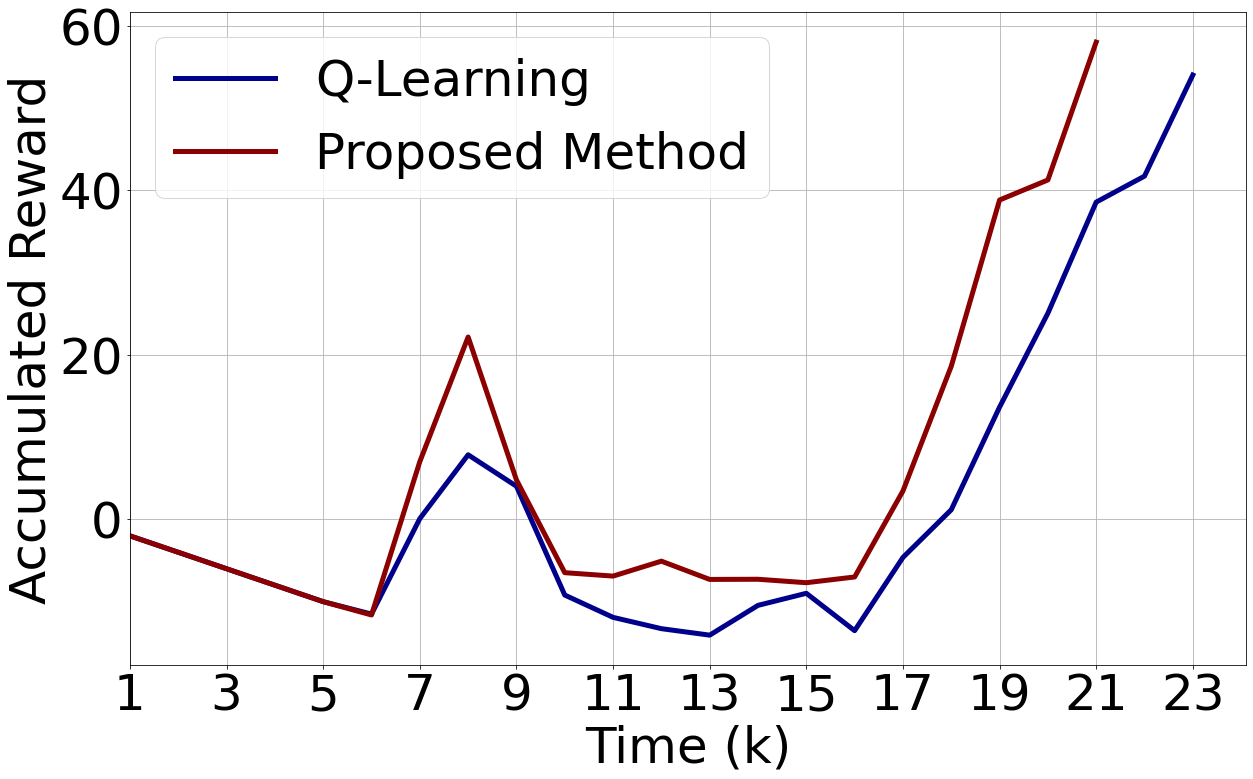

In [332]:
'''
plot the average of accumulated reward per time for regualr and minmax Q-learning
'''

accum_rewards_per_t = accumulate(nonrrl_rewards)

minmax_accum_rewards_per_t = accumulate(minmax_nonrrl_rewards)

steps = max(len(accum_rewards_per_t), len(minmax_accum_rewards_per_t))
t = np.arange(1,steps+1,1)
fig, axs = plt.subplots(1, 1, figsize=(20,12))

axs.plot(t[:len(accum_rewards_per_t)],accum_rewards_per_t, color='darkblue', label='Q-Learning', linewidth=5)

axs.plot(t[:len(minmax_accum_rewards_per_t)],minmax_accum_rewards_per_t,color='darkred', label='Proposed Method', linewidth=5)

axs.legend(loc='upper left')
axs.set_xlabel('Time (k)')
axs.set_ylabel('Accumulated Reward')
axs.set_xticks(np.arange(0, steps,1))
axs.grid()
axs.set_xlim(1)
axs.set_xticks(np.arange(1, steps+1,2))

plt.savefig('CAI2023_2.png',bbox_inches='tight')
plt.show()